In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2024-05-21 11:36:44.933953: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:36:44.940260: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:36:45.015809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 11:36:46.321766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
      training data
    y : ndarray, shape (n_samples, 1)
      Label of training data
    batch_size : int
      batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int64)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [3]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    A Simple three-layer neural network classifier

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, n_epoch = 50, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10,
                sigma = 0.01, n_batch = 20, activation_function = 'tanh', learning_rate = 0.01, verbose = True):
        # Record hyperparameters as attributes
        self.verbose = verbose
        self.n_epoch = n_epoch
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_batch = n_batch
        self.activate_function = activation_function
        self.lr = learning_rate
    
    def initial_weight(self):
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.b2 = np.zeros(self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.b3 = np.zeros(self.n_output) 
    
    def activation_function(self, X):
        if self.activate_function == 'sigmoid':
            return 1/(1 + np.exp(-X))
        elif self.activate_function == 'relu':
            return np.max(0.0, X)
        elif self.activate_function == 'tanh':
            return np.tanh(X)
    
    def softmax(self, X):
        return np.exp(X - np.max(X))/np.sum(np.exp(X-np.max(X)), axis = 1, keepdims= True)
    
    def loss_function(self, y, yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y + delta))
    
    def gradient_descent(self, X, y, yt):
        '''
        Calculate gradient descent
        '''
        # 3rd layer
        delta_a3 = (y-yt)/self.n_batch
        delta_b3 = np.sum(delta_a3, axis = 0)
        delta_W3 = np.dot(self.z2.T, delta_a3)
        delta_z2 = np.dot(delta_a3, self.W3.T)
        

        self.W3 -= self.lr * delta_W3
        self.b3 -= self.lr * delta_b3

        # 2nd layer
        if self.activate_function == 'sigmoid':
            delta_a2 = delta_z2 * (1-self.activation_function(self.z2))*self.activation_function(self.z2)
        elif self.activate_function == 'tanh':
            delta_a2 = delta_z2*(np.tanh(self.z2)**2)

        delta_b2 = np.sum(delta_a2, axis = 0)
        delta_W2 = np.dot(self.z1.T, delta_a2)
        delta_z1 = np.dot(delta_a2, self.W2.T)

        self.W2 -= self.lr * delta_W2
        self.b2 -= self.lr * delta_b2

        # 1st layer
        if self.activate_function == 'sigmoid':
            delta_a1 = delta_z1 * (1-self.activation_function(self.z1))*self.activation_function(self.z1)
        elif self.activate_function == 'tanh':
            delta_a1 = delta_z1*(np.tanh(self.z1)**2)

        delta_b1 = np.sum(delta_a1, axis = 0)
        delta_W1 = np.dot(X.T, delta_a1)

        self.W1 -= self.lr * delta_W1
        self.b1 -= self.lr * delta_b1


    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : ndarray, shape (n_samples, )
            Label of training data
        X_val : ndarray, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray, shape (n_samples, )
            Label of validation data
        """
        # initialize weights
        self.initial_weight()

        # the loss function for each epoch 
        self.log_loss = []
        self.log_loss_val = []

        self.log_acc = []
        self.log_acc_val = []

        for epoch in range(self.n_epoch):
            get_mini_batch = GetMiniBatch(X, y , batch_size = self.n_batch)
            self.loss = 0
            self.true_y = np.array([])
            self.pred_y = np.array([])

            for mini_X_train , mini_y_train in get_mini_batch:
                #1st layer
                self.z1 = self.activation_function(np.dot(mini_X_train, self.W1) + self.b1)

                #2nd layer
                self.z2 = self.activation_function(np.dot(self.z1, self.W2) + self.b2)

                #3rd layer
                yhat = self.softmax(np.dot(self.z2, self.W3) + self.b3)

                #backpropagation
                self.gradient_descent(mini_X_train, yhat, mini_y_train)

                #record correct and estimated values for mini batch data
                self.true_y = np.concatenate([self.true_y, np.argmax(mini_y_train, axis = 1)])
                self.pred_y = np.concatenate([self.pred_y, np.argmax(yhat, axis = 1)])

                # Loss function
                self.loss += self.loss_function(yhat, mini_y_train)
            
            # record loss function for each epoch
            self.log_loss.append(self.loss/len(get_mini_batch))

            #Accuracy
            acc = accuracy_score(self.true_y, self.pred_y)
            self.log_acc.append(acc)

            if (type(X_val) != bool):
                self.z1_val = self.activation_function(np.dot(X_val, self.W1) + self.b1)
                self.z2_val = self.activation_function(np.dot(self.z1_val, self.W2) + self.b2)
                yhat_val = self.softmax(np.dot(self.z2_val, self.W3) + self.b3)

                #loss function
                self.loss_val = self.loss_function(yhat_val, y_val)
                self.log_loss_val.append(self.loss_val)

                acc_val = accuracy_score(np.argmax(y_val, axis = 1), np.argmax(yhat_val, axis = 1))
                self.log_acc_val.append(acc_val)

            if self.verbose:
                print('epoch:{} loss:{} acc:{}'.format(epoch, self.loss/self.n_batch, acc))        

    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            training sample

        Returns
        -------
        pred:    ndarray, shape (n_samples, 1)
            predicted result
        """

        self.pred_z1 = self.activation_function(np.dot(X, self.W1) + self.b1)
        self.pred_z2 = self.activation_function(np.dot(self.pred_z1, self.W2) + self.b2) 
        pred = np.argmax(np.dot(self.pred_z2, self.W3) + self.b3, axis=1)
        return pred

## Dataset

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train data shape: ", X_train.shape) # (60000, 28, 28)
print("X_test data shape: ", X_test.shape) # (10000, 28, 28)

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train flatten data shape: ", X_train.shape) # (60000, 28, 28)
print("X_test flatten data shape: ", X_test.shape) # (10000, 28, 28)

X_train data shape:  (60000, 28, 28)
X_test data shape:  (10000, 28, 28)
X_train flatten data shape:  (60000, 784)
X_test flatten data shape:  (10000, 784)


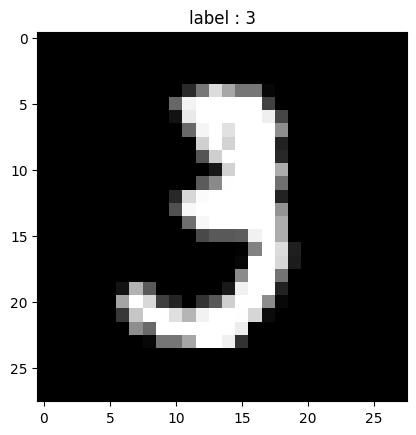

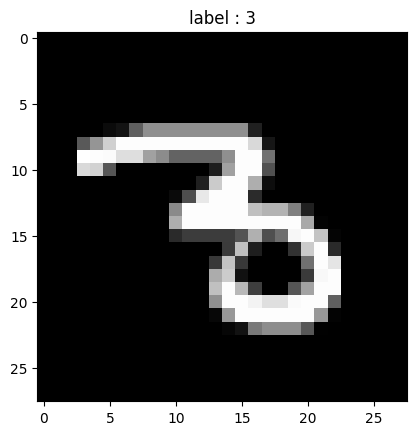

In [5]:
index = 10
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()


index = 30
image = X_train[index].reshape(28,28)
image = image.astype(np.float64) # Convert to float type
image -= 105.35 # Try to create a negative number on purpose
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

## Preprocessing

In [6]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train /= 255
X_test /= 255
print('X_train max value:', X_train.max()) # 1.0
print('X_train min value:', X_train.min()) # 0.0

# the correct label is an integer from 0 to 9, but it is converted to a one-hot representation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train.reshape(-1,1))
y_val_one_hot = enc.fit_transform(y_val.reshape(-1,1))
print("Train dataset:", X_train.shape) # (48000, 784)
print("Validation dataset:", X_val.shape) # (12000, 784)

X_train max value: 1.0
X_train min value: 0.0
Train dataset: (48000, 784)
Validation dataset: (12000, 784)


## Question 5 Estimation

In [7]:
clf = ScratchSimpleNeuralNetrowkClassifier(n_epoch = 25, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10,
                sigma = 0.01, n_batch = 20, activation_function = 'tanh', learning_rate = 0.01, verbose = True)
clf.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)
y_pred = clf.predict(X_val)
print(y_pred)


epoch:0 loss:27.502813989623995 acc:0.13020833333333334
epoch:1 loss:27.266728937031473 acc:0.1630625
epoch:2 loss:27.031576339472302 acc:0.26885416666666667
epoch:3 loss:26.790222742411753 acc:0.35785416666666664
epoch:4 loss:26.535867927133705 acc:0.4245625
epoch:5 loss:26.251221631970378 acc:0.473875
epoch:6 loss:25.83874369483628 acc:0.4578541666666667
epoch:7 loss:25.245022880668046 acc:0.3773958333333333
epoch:8 loss:23.94993317884695 acc:0.4364375
epoch:9 loss:21.31035361052583 acc:0.46241666666666664
epoch:10 loss:15.702660053421813 acc:0.5432916666666666
epoch:11 loss:12.795487482950236 acc:0.6457291666666667
epoch:12 loss:10.314025039524072 acc:0.7242916666666667
epoch:13 loss:9.075813202190748 acc:0.7614791666666667
epoch:14 loss:8.060771009201831 acc:0.7898541666666666
epoch:15 loss:7.503722003242322 acc:0.8018125
epoch:16 loss:7.017513761137248 acc:0.8143333333333334
epoch:17 loss:6.892872159530701 acc:0.8188541666666667
epoch:18 loss:6.996800943944753 acc:0.81602083333333

## Problem 6 Learning and Estimation

In [8]:
y_val_ = np.argmax(y_val_one_hot, axis = 1)
print(y_val_.shape)
acc = accuracy_score(y_val_, y_pred)
print('accuracy:{}'.format(acc))

(12000,)
accuracy:0.8419166666666666


## Problem 7 Plotting the learning curve

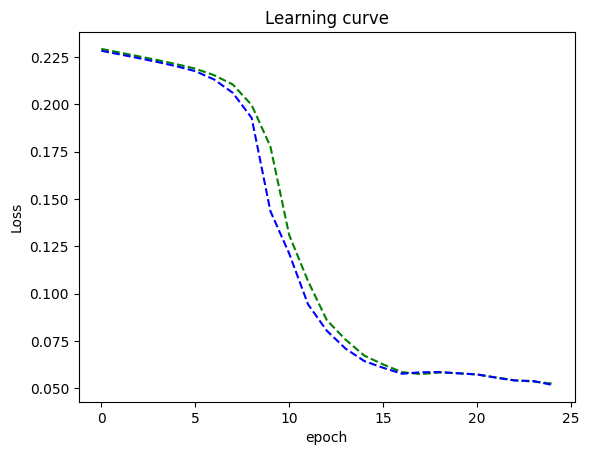

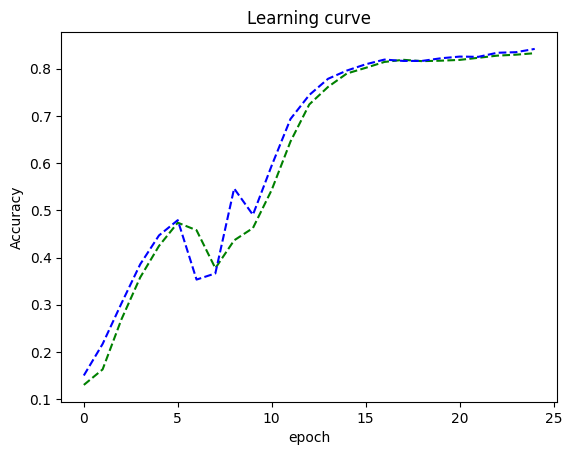

In [9]:
fig = plt.subplots()
plt.plot(clf.log_loss, 'g--')
plt.plot(clf.log_loss_val, 'b--')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Learning curve')
plt.show()

fig = plt.subplots()
plt.plot(clf.log_acc, 'g--')
plt.plot(clf.log_acc_val, 'b--')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title('Learning curve')
plt.show()

## Problem 8 (Advance Assignment) Confirmation of Misclassification

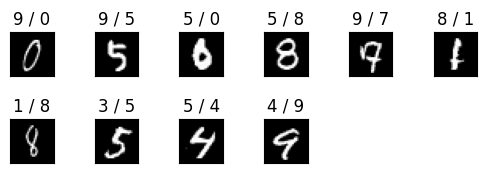

In [11]:
num = 10

true_false = y_pred==y_val_
false_list = np.where(true_false==False)[0].astype(np.intc)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val_[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')
plt.show()